In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
import os

In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])


In [4]:
train_data[train_data.duplicated(["class", "conversation"])]

,idx,class,conversation
392,392,1,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
523,523,2,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...
789,789,1,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...
824,824,1,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...
869,869,2,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...
...,...,...,...
3797,3797,1,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...
3798,3798,1,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...
3855,3855,1,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...
3874,3874,1,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...


In [5]:
train_data = train_data.drop_duplicates(subset=["class", "conversation"])

In [6]:
train_data[train_data.duplicated(["conversation"])]

,idx,class,conversation


In [7]:
corpus = train_data["conversation"]
corpus.head()

0    지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
Name: conversation, dtype: object

In [8]:
import sentencepiece as spm

def generate_spm_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # sentencepiece train을 위해 해당 corpus를 별도 파일로 만듬.
    temp_file = f"{lang}_corpus.txt"
    with open(temp_file, "w") as f:
        for sen in corpus:
            f.write(sen)
            f.write("\n")
    
    #  sentencepiece train
    model_name = f"{lang}_spm"
    spm.SentencePieceTrainer.train(input=temp_file, 
                                   model_prefix=model_name, 
                                   vocab_size=vocab_size, 
                                   pad_id=pad_id, 
                                   bos_id=bos_id, 
                                   eos_id=eos_id, 
                                   unk_id=unk_id)
    
    #  sentencepiece load
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name + ".model")
    
    return tokenizer

In [9]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)
    
    sentence = sentence.strip()

    return sentence

In [10]:
corpus = [preprocess_sentence(s) for s in corpus]

In [11]:
corpus[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 ? 진짜 죽여버리고 싶게 . 정말 잘못했습니다 . 너가 선택해 . 너가 죽을래 네 가족을 죽여줄까 . 죄송합니다 . 정말 잘못했습니다 . 너에게는 선택권이 없어 . 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 . 선택 못하겠습니다 . 한번만 도와주세요 . 그냥 다 죽여버려야겠군 . 이의 없지 ? 제발 도와주세요 .'

In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=None, 
        filters=' ',
        oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[ 3225  6564   343 ...    29  1061     2]
 [    2 15495  2348 ... 15501   121     2]
 [15512  9163 15513 ...   140  9164     4]
 ...
 [ 3024 50955 50956 ...  2652   209     3]
 [    2    48  3469 ...     2  1115     2]
 [ 2702  8746   585 ... 50977     2     7]] <keras_preprocessing.text.Tokenizer object at 0x7f833ceb08e0>


In [13]:
len(tokenizer.index_word)

50977

In [14]:
len_list = list(map(lambda s: len(s), corpus))

In [15]:
max(len_list)

909

In [16]:
min(len_list)

41

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_wh

<AxesSubplot:ylabel='Count'>

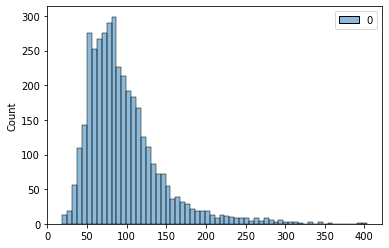

In [55]:
vocab_size = 10000

spm_tokenizer = generate_spm_tokenizer(corpus, vocab_size)
tokenized_corpus = []

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in range(len(corpus)):
    tokenized_corpus.append(spm_tokenizer.EncodeAsIds(corpus[idx]))
    
len_tokenized = [map(lambda s: len(s), tokenized_corpus)]
import seaborn as sns
sns.histplot(len_tokenized)

In [ ]:
from sklearn.model_selection import train_test_split

max_len = 100
X_train, X_val, y_train, y_val = train_test_split(tokenized_corpus, train_data['class'], test_size=0.2, random_state=42)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=max_len)

inputs = keras.layers.Input(shape=(None,))
x = keras.layers.Embedding(vocab_size, 128)(inputs)
# x = keras.layers.LSTM(256, return_sequences=True)(x)
x = keras.layers.LSTM(128)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs = 10)

Epoch 1/10
193/193 [==============================] - 4s 10ms/step - loss: 1.2550 - accuracy: 0.3771 - val_loss: 1.0013 - val_accuracy: 0.5052
Epoch 2/10
193/193 [==============================] - 1s 7ms/step - loss: 0.9872 - accuracy: 0.5244 - val_loss: 0.9848 - val_accuracy: 0.5078
Epoch 3/10
184/193 [===========================>..] - ETA: 0s - loss: 0.8189 - accuracy: 0.6104

In [72]:
test_data = pd.read_json("~/aiffel/dktc/data/test.json")
test_data.head()

,t_000,t_001,t_002,t_004,t_005,t_006,t_007,t_009,t_010,t_012,...,t_489,t_490,t_492,t_493,t_494,t_495,t_496,t_497,t_498,t_499
text,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...,예전에 네가 나한테 했던 일 기억하지? 너도 당해봐 예전 일이라면 내가 사과할게. ...,김비서 지금 우리애 학교가서 집에다가 좀 데려다 주세요 사장님 그런 개인적인 일은 ...,...,너 어제 집에 바로 안 들어갔지? 어떻게 알았어? 내가 눈이 좋아 왜 묻는건데? 너...,철수야 말 들어야지 싫은데 철밥통 선생아 너 선생님한테 말버릇이 뭐야 야 내가 너말...,동생이쁘다. 나주라 안돼 우리동생건들지마. 왜 안되냐? 좀 달라고 니 목숨값으로 동...,혹시 나 오늘 2만원만 빌려주만 안돼? 응? 안돼. 나도 요즘 맨날 택시타느라 택시...,이봐 네? 누구세요? 입다물고 가진거 다내놔 경찰에 신고할거에요 할 수 있으면 해봐...,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,엄마 저 그 돈 안해주시면 정말 큰일나요. 이유도 말하지 않고. 몇번째니 경민아....


In [73]:
test_data = test_data.transpose()
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...


In [74]:
test_corpus = [preprocess_sentence(s) for s in test_data["text"]]
tokenized_test_corpus = []
for idx in range(len(test_corpus)):
    tokenized_test_corpus.append(spm_tokenizer.EncodeAsIds(test_corpus[idx]))

In [75]:
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test_corpus, padding='post', maxlen=max_len)

In [76]:
predicted = model.predict(X_test)

In [77]:
tf.shape(predicted)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([400,   4], dtype=int32)>

In [78]:
import numpy as np

predicted = np.argmax(predicted, axis=-1)

In [79]:
predicted

array([0, 2, 2, 2, 3, 2, 0, 0, 3, 2, 2, 0, 3, 1, 3, 1, 1, 0, 0, 2, 2, 0,
       3, 0, 1, 1, 1, 3, 3, 0, 3, 0, 2, 0, 2, 3, 1, 3, 0, 1, 0, 2, 2, 3,
       1, 1, 2, 0, 3, 3, 1, 2, 3, 1, 1, 1, 2, 1, 2, 0, 2, 0, 2, 3, 3, 1,
       2, 3, 0, 2, 2, 3, 1, 2, 2, 3, 3, 0, 3, 2, 2, 2, 1, 3, 3, 3, 2, 1,
       0, 2, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1,
       0, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 2, 1, 3, 1, 3, 2, 2, 1, 3, 2, 2,
       1, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 3, 3, 1, 3, 3, 0, 1, 0, 1, 3, 3,
       3, 2, 3, 1, 1, 3, 1, 2, 3, 2, 2, 1, 2, 2, 0, 3, 3, 0, 3, 1, 2, 3,
       0, 3, 1, 3, 3, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 3, 3,
       3, 2, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 3, 3, 2, 2, 2, 1, 2, 2, 0, 3,
       1, 2, 2, 0, 2, 3, 1, 0, 0, 1, 1, 2, 1, 0, 3, 1, 3, 2, 0, 0, 2, 3,
       0, 2, 3, 0, 3, 2, 1, 0, 1, 1, 3, 2, 3, 3, 0, 0, 0, 1, 2, 1, 3, 3,
       3, 1, 0, 1, 0, 1, 3, 2, 3, 3, 0, 2, 0, 3, 3, 3, 1, 0, 0, 2, 1, 1,
       3, 1, 3, 0, 0, 2, 3, 2, 1, 1, 1, 2, 3, 2, 2,

In [80]:
submission = pd.read_csv("~/aiffel/dktc/data/submission.csv")

In [81]:
submission.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_004,NaN
4,t_005,NaN


In [82]:
submission['class'] = predicted

In [83]:
submission.to_csv("hihi2.csv", index=False) ## 32.5%

In [70]:
len(submission)

400